**IMPORTING LIBRARIES**

In [1]:
import os 
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout
from keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.models import load_model

In [2]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

**LOADING DATA**

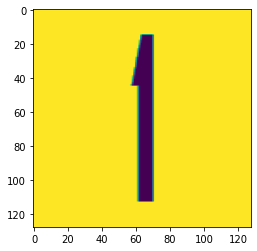

In [3]:
data_dir = 'Data'
img = cv2.imread(os.path.join(data_dir,'1','img002-00001.png'))
# print(img.shape)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
plt.show()

**CREATING DATASET**

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,color_mode='grayscale',image_size=(32,32),label_mode='categorical')
# label_mode = 'Categorical'.....will perform One-Hot encoding

Found 10160 files belonging to 10 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0][0].shape

(32, 32, 1)

In [6]:
batch[1].shape

(32, 10)

c:\Users\ASUS\miniconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


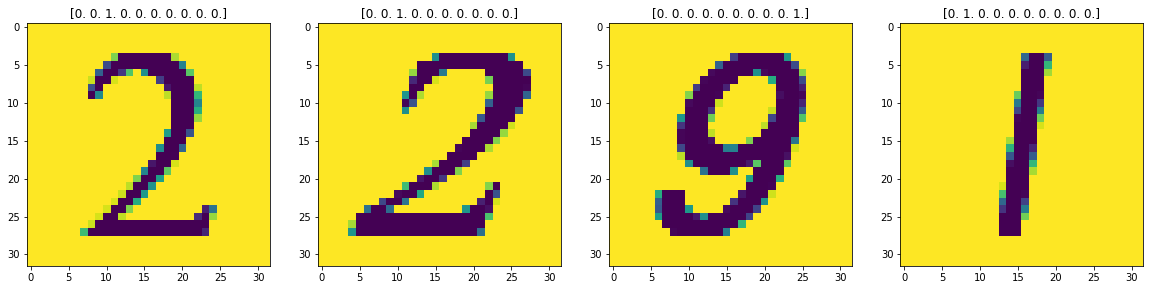

In [7]:
fig,ax = plt.subplots(ncols=4,figsize= (20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**NORMALIZING THE DATA**

In [8]:
data = data.map(lambda x,y:(x/255,y))

**SPLITING DATASET**

In [9]:
train_size = int(len(data)*0.7)
val_size  =int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1
print(train_size,val_size,test_size)
# train_size = 7721
# val_size  = 1931
# test_size = 508

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


222 64 32


**BUILDING MODEL**

In [10]:
model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                    

**TRAINING MODEL**

In [12]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
222/222 [==============================] - 19s 50ms/step - loss: 0.6367 - accuracy: 0.7784 - val_loss: 0.0982 - val_accuracy: 0.9683
Epoch 2/20
222/222 [==============================] - 7s 31ms/step - loss: 0.1106 - accuracy: 0.9627 - val_loss: 0.0572 - val_accuracy: 0.9834
Epoch 3/20
222/222 [==============================] - 7s 30ms/step - loss: 0.0691 - accuracy: 0.9780 - val_loss: 0.0555 - val_accuracy: 0.9839
Epoch 4/20
222/222 [==============================] - 7s 30ms/step - loss: 0.0619 - accuracy: 0.9817 - val_loss: 0.0309 - val_accuracy: 0.9912
Epoch 5/20
222/222 [==============================] - 8s 35ms/step - loss: 0.0407 - accuracy: 0.9872 - val_loss: 0.0304 - val_accuracy: 0.9888
Epoch 6/20
222/222 [==============================] - 7s 33ms/step - loss: 0.0477 - accuracy: 0.9838 - val_loss: 0.0273 - val_accuracy: 0.9907
Epoch 7/20
222/222 [==============================] - 8s 34ms/step - loss: 0.0366 - accuracy: 0.9890 - val_loss: 0.0213 - val_accuracy: 0.993

**PLOTING MODEL PERFORMANCE**

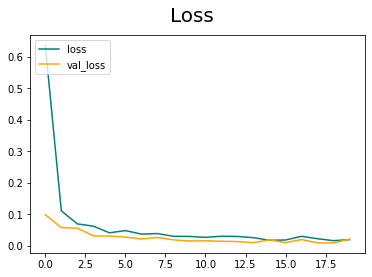

In [13]:
# LOSS
fig = plt.figure()
plt.plot(hist.history['loss'],color= 'teal',label = 'loss')
plt.plot(hist.history['val_loss'],color = 'orange',label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

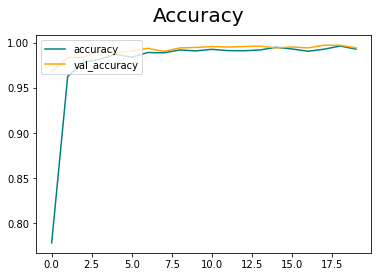

In [14]:
# ACCURACY
fig = plt.figure()
plt.plot(hist.history['accuracy'],color = 'teal',label = 'accuracy')
plt.plot(hist.history['val_accuracy'],color = 'orange',label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

**EVALUATING MODEL ON TEST SET**

In [15]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [16]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 224ms/step


In [17]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9970208406448364, Recall:0.9960317611694336, Accuracy:0.9960317611694336


**SAVING MODEL**

In [18]:
model.save(os.path.join('Model','OCR.h5'))

: 